# Data jobs. Are they truly different?

**Data scientis, data analysit, AI specialist, ML engineer, big data consultant, statistician, data enthusiast. Who is who?**

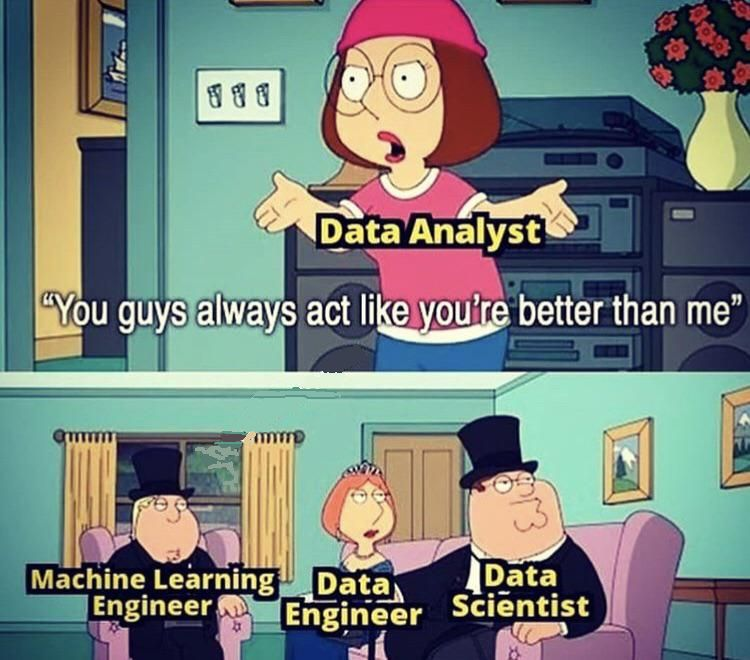


In my team we are four people and we all do very similar work: two data scientists, an AI specialist and a machine learning engineer. I have a masters in Statistics, so I was considering myself a statistician. My first job was of data analyst, then I became a big data consultant, and then my job title changed without any of my tasks or skills dramatically following, to AI specialist. I would consider myself more as a "jack of all trades", but that isn't a professional role naming.

What I would like to understand with this analysis is: what skills and job responsibilities make the difference between the data sicence roles. **In theory we do have definitions of what each role should do, but do these apply in practice?** Are people in data science, really acting within the standard responsibilities, or are they going beyond them?

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from textwrap import wrap
import networkx as nx

from itertools import combinations
from igraph import *

import warnings
warnings.filterwarnings('ignore')
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

For this purpose, I choose only the data related job titles, which are six in total. I also added a short description of what each role could entail, as per (https://www.northeastern.edu/graduate/blog/data-science-careers-shaping-our-future/).

### Data Scientist 
Typical Job Requirements: Find, clean, and organize data for companies. Data scientists will need to be able to analyze large amounts of complex raw and processed information to find patterns that will benefit an organization and help drive strategic business decisions.

### Data Analyst
Typical Job Requirements: Transform and manipulate large data sets to suit the desired analysis for companies. Data analysts also aid in the decision-making process by preparing reports for organizational leaders.

### Machine Learning Engineer
Typical Job Requirements: Machine learning engineers create data funnels and deliver software solutions. They typically need strong statistics and programming skills, as well as a knowledge of software engineering. In addition to designing and building machine learning systems, they are also responsible for running tests and experiments to monitor the performance and functionality of such systems.

### Data Engineer
Typical Job Requirements: Perform batch processing or real-time processing on gathered and stored data. Data engineers are also responsible for building and maintaining data pipelines which create a robust and interconnected data ecosystem within an organization, making information accessible for data scientists.

### DBA/Database Engineer
Typical Job Requirements: Ensure data solutions are built for performance and design analytics applications for multiple platforms. In addition to creating new database systems, they often find ways to improve the performance and functionality of existing systems, as well as working to provide access to database administrators and analysts.

### Statistician
Typical Job Requirements: Statisticians work to collect, analyze, and interpret data in order to identify trends and relationships which can be used to inform organizational decision-making. Additionally, the daily responsibilities of statisticians often include design data collection processes, communicating findings to stakeholders, and advising organizational strategy.

In [ ]:
# Read the data and filter the roles:

data_df = pd.read_csv("/kaggle/input/kaggle-survey-2020/kaggle_survey_2020_responses.csv")
data_df = data_df.drop_duplicates()

_data_df = data_df[(data_df.Q5 == "Data Scientist") | 
                   (data_df.Q5 == "Data Analyst") | 
                   (data_df.Q5 == "Machine Learning Engineer") | 
                   (data_df.Q5 == "Data Engineer") | 
                   (data_df.Q5 == "DBA/Database Engineer")|
                   (data_df.Q5 == "Statistician")].reset_index(drop=True).iloc[:,1:]

## The role frequency in the survey

The data related job titles, which are six in total, are represented in the bar chart.

Most of the respondents are data scientists, followed by data analysts and ML engineers. Due to the unballance in the data, the numbers reported will be normalized.

In [ ]:
_data_df[["Q1", "Q5"]].groupby(["Q5"]).count().plot.barh(color="lightblue", figsize = (10, 6))
plt.show()

# Community detection analysis

The survey includes one question of interest for this study (Q23), where each person listed the activities that make a big part of their role. This is a multiple choice question, so in order to draw conclusions, we create a graph of people. Each node in the graph represents one person and a link between two persons was calculated as:

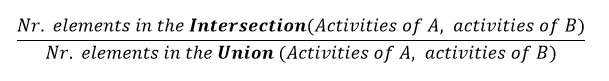 , where A and B are nodes in the graph.



The values range between 0 and 1, where 0 mean no similarity and 1 means perfectly similar activities.

For visualization purposes I only selected 1000 nodes (to minimize the runtime).

#### Colors in the graph:
- <span style="background-color: pink; color: white;"><b>Data Analyst</b></span>
- <span style="background-color: lightgreen; color: white;"><b>Data Engineer</b></span>
- <span style="background-color: lightblue; color: white;"><b>Data Scientist</b></span>
- <span style="background-color: yellow; color: white;"><b>Machine Learning Engineer</b></span>
- <span style="background-color: purple; color: white;"><b>DBA/Database Engineer</b></span>'
- <span style="background-color: gray; color: white;"><b>Statistician</b></span>

**In the first graph** we see how people with different roles are linked together, based on the type of activities they consider most important in their role. We fix a threshold of at least 0.5 similarity score, for a link to exist. 

Based on who they link with, we are performing community detection (**second graph**), which is a more complex clustering, which besides the person's features, also takes into consideration it's connections. 

In [ ]:
selected_cols = [col.startswith("Q5") | col.startswith("Q23") for col in _data_df.columns]

# Select inly some observations (for visualization purposes)
ppl_df = _data_df.iloc[:1000,selected_cols]

# Generate vertices combinations (edges)
print("Generating edges (node combinations)...")
df_nodes = pd.DataFrame(data = list(combinations(ppl_df.index.to_list(),2)),
                       columns = ["Source", "Target"])


# Function to calculate the edge weights between every two nodes (vertices)
def calc_weight(df, x):
    numerator = sum([ a == b for a, b in zip(df.loc[x.Source].values[1:], df.loc[x.Target].values[1:])])
    denominator = sum([pd.notna(a) | (pd.notna(b)) for a, b in zip(df.loc[x.Source].values[1:], df.loc[x.Target].values[1:])])

    try:
        weight = numerator/denominator
    except ZeroDivisionError:
        weight = 0.0
        
    return weight

# Calculate the edge weights
weights = df_nodes.apply(lambda x: calc_weight(ppl_df, x), axis=1)
df_nodes["weights"] = round(weights, 1)*100

# igraph allows loading a graph from tuples
tuples = [(int(row[0]), int(row[1])) for row in df_nodes.values]

# Map every role to a color to be represented in the graph
job_cols = {
    'Data Analyst':"pink",
    'Data Engineer':"lightgreen",
    'Data Scientist':"lightblue",
    'Machine Learning Engineer':"yellow",
    'DBA/Database Engineer': "purple",
    'Statistician':"gray"}

job_col_lst = list(map(job_cols.get, list(ppl_df.Q5)))

# Generate the graph network from tuples
g = Graph(tuples)

In [ ]:
# Add the edge and node properties: edge weights, node colors and job corresponding to each node
g.es["weight"]=(df_nodes["weights"])

# Delete the edges of 0 weight
g.es.select(weight = 0).delete()
g.es.select(weight = 5).delete()
g.es.select(weight = 10).delete()
g.es.select(weight = 15).delete()
g.es.select(weight = 20).delete()
g.es.select(weight = 25).delete()
g.es.select(weight = 30).delete()
g.es.select(weight = 35).delete()
g.es.select(weight = 40).delete()
g.es.select(weight = 45).delete()
# g.es.select(weight = 50).delete()
# g.es.select(weight = 55).delete()
# g.es.select(weight = 60).delete()
# g.es.select(weight = 65).delete()
# g.es.select(weight = 70).delete()
# g.es.select(weight = 75).delete()
# g.es.select(weight = 80).delete()
# g.es.select(weight = 85).delete()
# g.es.select(weight = 90).delete()
# g.es.select(weight = 95).delete()
# g.es.select(weight = 100).delete()


# Delete the unconnected nodes
g.vs.select(_degree=0).delete()

g.vs["job"] = ppl_df.Q5.values
g.vs["job_cols"] = job_col_lst

In [ ]:
layout = g.layout_fruchterman_reingold()
#layout = g.layout_lgl()
#layout = g.layout_kamada_kawai()

plot(g, layout=layout,
     bbox = (600, 300), 
     margin = 20, 
     vertex_color = g.vs['job_cols'], 
     vertex_size = 5,
     edge_color = "lightgray",
     edge_width = ([i/50 for i in g.es['weight']]))

**Community Detection** is one of the fundamental problems in network analysis, where the goal is to find groups of nodes that are, in some sense, more similar to each other than to the other nodes. Our community detection algorithm identifies several groups of people, each group represented by one color in the network plot below, with high similarity within the groups and high dissimilarity between the groups. 

The question arising is: **Are the groups the same as the job roles?**
The answer is NO. We keep the same position of the original graph and see how, the nodes in the <span style="background-color: red; color: white;"><b> red comunity </b></span> correspond to data analysts, data scientists, ..., indicating  that it is likely that in practice, people with different roles, actually perform tasks similar to other roles. Therefore, in practice, **we don't have strict boundries between roles in terms of activities.**

In [ ]:
community = g.community_multilevel()
print("Number of identified communities: {}".format(max(community.membership)+1))
#community = g.community_edge_betweenness().as_clustering()
color_list = ["pink", 'lightblue', "lightgreen","purple", "red", "blue","yellow"]

plot(community, layout=layout, vertex_size=5, bbox = (600, 300),
     vertex_color=[color_list[x] for x in community.membership])

In [ ]:
# # calculate dendrogram
# dendogram = g.community_fastgreedy()
# # convert it into a flat clustering
# clusters = dendrogram.as_clustering()
# # get the membership vector
# membership = clusters.membership

# plot(dendogram)

Let's further explore the actitivies with respect to the roles.

# The activities that make an important part of the role

In order to look for differences between each role's activities, we use a parrallel coordinates plot. Each color/ job code represents a role, as following:
- 0 := DAB/ Database engineer
- 1 := Data analyst
- 2 := Data engineer
- 3 := Data scientist
- 4 := ML engineer
- 5 := Statistician

On all other axis, we rank each activity according to the number of times a person considers it relevant for his/her job. The highest rank is 1 and the lowest is 8.

In [ ]:
selected_cols = [col.startswith("Q5") | col.startswith("Q23")  for col in _data_df.columns]
_lang = _data_df.iloc[:,selected_cols]

# _lang.columns = ["Q5","Analyze and understand data to influence product or business decisions", 
# "Build and/or run the data infrastructure that my business uses for storing, analyzing, and operationalizing data",
# "Build prototypes to explore applying machine learning to new areas",
# "Build and/or run a machine learning service that operationally improves my product or workflows",
# "Experimentation and iteration to improve existing ML models",
# "Do research that advances the state of the art of machine learning",
# "None of these activities are an important part of my role at work",
# "Other"]

_lang.columns = ["\n".join(wrap(i, 40)) for i in _lang.columns]

# ["Q5","Python","R", "SQL", "C", "C++","Java", "Javascript", "Julia", "Swift", "Bash", "MATLAB", "None", "Other"]

_lang[_lang.iloc[:,1:].notna() ==  True] = 1
_lang[_lang.iloc[:,1:].notna() ==  False] = 0

In [ ]:
# Rank the activities
rank_activities = _lang.groupby(["Q5"]).sum().rank(ascending=False,axis=1).reset_index()
rank_activities["color"] = [0,1,2,3,4,5]

fig = px.parallel_coordinates(rank_activities,color = rank_activities.color, #['pink','light green','light blue', 'yellow', 'purple', 'gray']
                              labels = {'color': "job", 
                                        'Q23_Part_1': 'Analize and understand data', 
                                        'Q23_Part_2': 'Build data infrastructure', 
                                        'Q23_Part_3': 'Build prototypes to explore ML', 
                                        'Q23_Part_4': 'Build/run ML services',
                                        'Q23_Part_5': 'Experimentation to improve exist. ML', 
                                        'Q23_Part_6': 'Reaserch on ML advances', 
                                        'Q23_Part_7': 'None', 
                                        'Q23_OTHER': "Other"},
                              dimensions =['color', 'Q23_Part_1', 'Q23_Part_2', 'Q23_Part_3', 'Q23_Part_4',
       'Q23_Part_5', 'Q23_Part_6', 'Q23_Part_7', 'Q23_OTHER'])

fig.show()

### Interpretation:

The most important activity for **DAB/Database engineers** (code:0) is to **build and/or run the data infrastructure** that the business uses for storing, analyzing, and operationalizing data. On the second position is understanding and analyzing the data.

For **Data analysts, Data scientists, Data engineers and Statisticians** the number one priority is analyzing and understanding the data. Data analysts, data engineers and statisticians are more involved in building and running the data infrastructure that the bussiness uses, they explore new areas where ML could be used by building prototypes and experiment with existing ML techniques. Data scientists are not building data infrastructures so much, but they consider an important part of their job to build and/or run machine learning services that operationally improves a product or workflows.

**ML engineers** are focusing on building prototypes to explore applying machine learning to new areas, experimenting and iterating to improve existing ML models and building and/or running machine learning services. They don't contribute to building the data infrastructure, but they spend much time understanding the data that goes into their models.


When it comes to the most solid technical background, needed in order to advance the research in ML, statisticians seem to contribute the most.

Two of the activities mentioned above rank highly among **all data science roles** we are looking at, and they are related to machine learning:

- Build prototypes to explore applying machine learning to new areas
- Experimentation and iteration to improve existing ML models

Let's see how much experience in using machine learning algorithms do people in each role have:

In [ ]:
f = lambda x: x/sum(x)

selected_cols_ml = [col.startswith("Q5") | col.startswith("Q15")  for col in _data_df.columns]
_ml = _data_df.iloc[:,selected_cols_ml]
_ml["I"] = [1] * len(_ml)

fig, ax = plt.subplots(ncols = 1, nrows = 1, figsize = (15, 8))


z = _ml.groupby(['Q15', 'Q5']).count().unstack("Q5")

idx = ['I do not use machine learning methods','Under 1 year', '1-2 years', '2-3 years',
       '3-4 years', '4-5 years', '5-10 years','10-20 years', '20 or more years' ]

z = z.loc[idx,:]

z.apply(f).T.plot.barh( stacked=True, ax = ax)

ax.set_title("The number of years of general ML experience by role (% of the role's total)")
plt.show()

### Interpretation:
The role with the least machine learning experience is that of **data analyst**, with almost 60% of practitioners not using ML methods, or using them for less than a year. This is also the role with the lowest number of highly experience ML users, under 5% having more than 5 years of general machine learning experience.

10 to 20% of **data scientists, machine learning engineers and statisticians** are highly experienced, with over 5 years of ML experience. The highest percentage of data professionals with over 20 years of experience are statisticians. Data scientists' and machine learning engineers' populations are characterized by a low number of peers not using ML methods (under 5%), and a high share of novices (between 40 and 50% of the total).

It is interesting to observe a similar percent of professionals with 2-3 years of experience across all roles, as well as that for some jobs (data scientist, statistician) the shares with higher experience are almost equal, as if there would be a "role retention" across time.



This gives rise to aother question: **How advanced are the machine learning algorithms used by each profession?**

# The ML algorithms used on a regular basis (Q17)

Linear and logistic regression constitute the foundation, the first algorithms we learn as data science people. Linear regression is applied when the response variable is continuous and logistic regression is used for binary classification.

Decision trees are a more complex, rule based algorithm, mostly preferred in situation when we need transparency. The results are easy to interpret due to its tree-like structure. The disadvantage is their randomness. Random forest is an ensamble method, which aggregates the results of multiple trees. 

Gradient boosting is also linked to decision trees, specifically an ensamble algorithm trying to transform multiple weak learners into a strong one.

Bayesian approaches apply probabilities to statistical problems. Bayesian statistics reqire solid mathematical background. If you've heard of hypothesis testing, Markov Chains and Monte Carlo, they are all Bayesian approaches.

Neural networks come in many shapes and forms and their usage increased in the last years. From convolutional neural networks for image classification, to GANs for synthetic data generation, to U-nets for segmentation or YOLO for detection, everybody seems to be using them.

Evolutionary approaches are inspired from biology, but not many of the respondents use them.

In [ ]:
selected_cols_Q17 = [col.startswith("Q5") | col.startswith("Q17")  for col in _data_df.columns]

lang_mix = _data_df.iloc[:,selected_cols_Q17]

lang_mix.columns = ["Q5","Linear or Logistic Regression",
                      "Decision Trees or Random Forests",
                   "Gradient Boosting Machines (xgboost, lightgbm, etc)",
                    "Bayesian Approaches",
                    "Evolutionary Approaches",
                    "Dense Neural Networks (MLPs, etc)",
                    "Convolutional Neural Networks",
                    "Generative Adversarial Networks",
                    "Recurrent Neural Networks", 
                    "Transformer Networks (BERT, gpt-3, etc)",
                    "None",
                    "Other"]

lang_mix[lang_mix.iloc[:,1:].notna() ==  True] = 1
lang_mix[lang_mix.iloc[:,1:].notna() ==  False] = 0

In [ ]:
fig, ax = plt.subplots(figsize=(12,8))

sns.heatmap(lang_mix.groupby(["Q5"]).apply(lambda x: x.sum()/len(x)), 
           cmap="YlGnBu")

plt.show()

### Interpretation:
As expected, everybody can do a bit of machine learning. Linear regression, logistic regression, decision trees and random forests are a must. 
Statisticians, as they have a solid mathematical background and know their way around probabilities, also have the knowledge to use Bayes approaches.
Machine learning engineers are the group which uses neural networks the most, with convolutional neural networks in the top of their preferrences. ML engineers cover the largest spectrum of algorithms, followed by data scientists.

### **How come, the roles in data science, overlap so much?** 

One hypothesis might be **the use of a common programming language**. Another hypothesis could be **the need to understand the data**, in order to draw the correct, realistic conclusions.
Let's start with the first one:

# Programming languages used on a regular basis (Q7)

There are some programming languages we expect a data science professional to use: R is known for it's diversity of algorithms, Python has some useful libraries, with MATLAB we are used since the university years. But what is even more interesting, is what combinations of languages do they use, given their job title.

I chose **graph networks** in order to visualize the programming languages used by these professionals. This way, we can go beyond "single value" histograms and observe co-occurences. 
A graph is built if nodes (or vertices) and edges (links between the vertices). In this case, each node represents a programming language. The width of an edge represents how often are two programming languages used by the same person.

The goal is to observe any similar patterns between different jobs, in terms of programming skills. Given the data unballance, we normalize all values, so reliable conclusions can be drawn.


In [ ]:
# Extract columns starting with "Q7": "What programming languages do you use?" and rename the columns clearly.

selected_cols = [col.startswith("Q5") | col.startswith("Q7")  for col in _data_df.columns]
_lang = _data_df.iloc[:,selected_cols]
_lang.columns = ["Q5","Python","R", "SQL", "C", "C++","Java", "Javascript", "Julia", "Swift", "Bash", "MATLAB", "None", "Other"]

_lang[_lang.iloc[:,1:].notna() ==  True] = 1
_lang[_lang.iloc[:,1:].notna() ==  False] = 0

In [ ]:
fig, ax = plt.subplots(3,2,num=1, figsize = (15,25))
[axi.set_axis_off() for axi in ax.ravel()]

r = 0
c = 0

for job in list(set(_lang.Q5)):

    #plt.figure()
    _job_df = _lang[_lang.Q5 == job].iloc[:,1:]
    nr_ppl = len(_job_df)
    
    # Generate the co-occurance matrix
    _job_adj = _job_df.T.dot(_job_df)
    
    exclusive_lang = np.diag(_job_adj)/nr_ppl
    
    # Normalize to the total
    total = sum(sum(_job_adj.values))
    diag = sum(np.diag(_job_adj))
    _job_adj = _job_adj/((total-diag)/2 + diag)
    
    _job_adj = pd.DataFrame((_job_adj.values.tolist()))
    _job_adj.columns = _job_df.columns
    _job_adj.index = _job_df.columns

    # Generate the graph 

    G = nx.from_pandas_adjacency(_job_adj)

    #nodelist = G.nodes()
    n_size = [float(ech)*2000 for ech in exclusive_lang]

    w = nx.get_edge_attributes(G, 'weight')
    edge_w = [ech*100 for ech in list(w.values())]
    nodelist=G.nodes()

    pos = nx.shell_layout(G)
    
    
    #ax[c,r].scatter(r,c)
                    
    nx.draw_networkx_nodes(G,pos,
                           nodelist=G.nodes(),
                           node_size=n_size,
                           node_color='lightgray',
                           alpha=0.7,
                           ax = ax[c,r])
    nx.draw_networkx_edges(G,pos,
                           edgelist = w.keys(),
                           width=edge_w,
                           edge_color='lightblue',
                           alpha=0.6,
                           ax = ax[c, r])
    
    nx.draw_networkx_labels(G, pos=pos,
                        labels=dict(zip(nodelist,nodelist)),
                        font_color='black',
                        font_size= 10,
                        ax = ax[c,r])
    
    ax[c,r].set_title(job, fontsize=12)
    
    c = c + 1
    if (c)%3==0:
        c = 0
        r = r + 1


### Interpretation:

The programming language graphs of Data Analysts and Data Scientists look alike: different combinations between Python, SQL and R, as well as high usage of these languages as standalone. 

Statisticians use R the most, sometimes together with SQL or SQL and Python.

DBA/Database Engineers and Data Engineers use SQL and Python together, but also together with Bash.

ML Engineers seem to use Python the most, as standalone. When they combine it with other programming languages they choose C, C++, Java, so we might be tempted to believe they have a more programming-oriented background.

Now, let's look at the top 12 programming language combinations and see if our conclusions stay valid.

In [ ]:
lang_mix = _data_df.iloc[:,selected_cols]

combo_lang = []

for idx, row in lang_mix.iloc[:,1:].iterrows():
    combo_lang.append(";".join(list(row[row.notnull()])))
    
lang_mix["lg_mix"] = combo_lang
lang_mix["I"] = [1] * len(lang_mix)
lang_mix = lang_mix[["Q5", "lg_mix", "I"]]

lang_count = lang_mix.groupby([ 'Q5', 'lg_mix']).count()['I'].reset_index().sort_values(by=["Q5","I"], 
                                                                                        ascending=[True, False]).reset_index(drop=True)

fig, ax = plt.subplots(3, 2,num=1, figsize = (15,25))
#ax.ravel()[-1].set_axis_off()
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.4, hspace=None)


r = 0
c = 0

for job in list(set(_lang.Q5)):
    _job_df = lang_count[lang_count.Q5 == job].reset_index(drop=True)
    nr_ppl = sum(_job_df["I"])
    
    _job_df["I"] = _job_df["I"]/nr_ppl
    
    #Select first 10
    _10 = _job_df[0:12].sort_values(by="I")
    
    ax[c,r].barh(_10["lg_mix"], _10["I"], color = "lightblue")
    
    ax[c,r].set_title(job, fontsize=12)
    c = c + 1
    if (c)%3==0:
        c = 0
        r = r + 1


Let's have a closer look at how much general programming experience do data science people have.

Only ~ 40% of data analysts have more than 3 years of experience in programming. On the opposite side we have DBA/Database engineers and Data engineers, with more than half of their peers programming for more than 5 years.

Data scientists, ML engineers and Statisticians have a similar distribution of coding experience.

In [ ]:
# How many years in programming?

selected_cols = [col.startswith("Q5") | col.startswith("Q6")  for col in _data_df.columns]
_prg = _data_df.iloc[:,selected_cols]
_prg["I"] = [1] * len(_prg)

f = lambda x: x/sum(x)



fig, ax = plt.subplots(ncols = 1, nrows = 1, figsize = (15, 8))

z = _prg.groupby(['Q6', 'Q5']).count().unstack("Q5")

idx = ['I have never written code', '< 1 years', '1-2 years','3-5 years', '5-10 years', '10-20 years', '20+ years']

z = z.loc[idx,:]

z.apply(f).T.plot.barh( stacked=True, ax = ax)


ax.set_title("The number of years of general programming experience by role (% of the role's total)")

plt.show()


z = _ml.groupby(['Q15', 'Q5']).count().unstack("Q5")




In order to explore the second hypothesis, we inspect the use of visualization libraries.

# Visualization libraries mostly used (Q14)

When it comes to vizualization libraries used by the data science professionals, it ofthen happens that only one library is not sufficient, so we find combinations of two or even more, depending on the programming language used.

40% of database engineers do not use any visualization tools. Those who use such tools, choose libraries provided in Python, such as seaborn and matplotlib.

Statisticians, who mainly use R, choose the vizualization tools available in R: ggplot, ggplot2 and shiny. 

Something that cought my eye, was the high percentage of data analysts who stated they don't use any visualization tool. I was expecting this to be the job with most data inspection...

Data engineers, data scientists and ML engineers use similar data visualization tools.

In [ ]:
# Q14 Visualization libraries used on a regular basis:

selected_cols_Q14 = [col.startswith("Q5") | col.startswith("Q14")  for col in _data_df.columns]

viz_mix = _data_df.iloc[:,selected_cols_Q14]

combo_viz = []

for idx, row in viz_mix.iloc[:,1:].iterrows():
    combo_viz.append(";".join(list(row[row.notnull()])))
    
viz_mix["viz_mix"] = combo_viz
viz_mix["I"] = [1] * len(viz_mix)
viz_mix = viz_mix[["Q5", "viz_mix", "I"]]

#lang_mix.ide_mix[lang_mix.ide_mix == ""] = "None"
viz_mix = viz_mix[viz_mix.viz_mix != ""]
viz_count = viz_mix.groupby([ 'Q5', 'viz_mix']).count()['I'].reset_index().sort_values(by=["Q5","I"], 
                                                                                        ascending=[True, False]).reset_index(drop=True)





In [ ]:
fig, ax = plt.subplots(3,2,num=1, figsize = (15,25))
#ax.ravel()[-1].set_axis_off()
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.5, hspace=None)


r = 0
c = 0

for job in list(set(_lang.Q5)):
    _job_df = viz_count[viz_count.Q5 == job].reset_index(drop=True)
    nr_ppl = sum(_job_df["I"])
    
    _job_df["I"] = _job_df["I"]/nr_ppl
    
    #Select first 10
    _10 = _job_df[0:10].sort_values(by="I")
    labels = ["\n".join(wrap(i, 30)) for i in _10["viz_mix"]]
    
    ax[c,r].barh(labels, _10["I"], color = "lightblue")
    
    ax[c,r].set_title(job, fontsize=12)
    c = c + 1
    if (c)%3==0:
        c = 0
        r = r + 1

### Interpretation:

So, if there is a difference between these jobs in terms of visualizations, it is not related to the tools, but to the type of plots interesting to each profession. Data engineers, who are monitoring pipelines, could use the same library as the ML engineers monitoring an algorithm's performance metrics, or the data analyst performing some exploratory analysis of data.

# Final Conclusions


- Analyzing and understanding the data is in **top 3 important activities** for all roles in data science, from DAB/Database engineer to the data analyst.
- All data science jobs require some **basic understanding of ML algorithms**, as well as the ability to put them in practice, in different business contexts.
- Machine Learning Engineers have strong programming skills, and are able to use a diverse range of algortithms, from liniar regression to neural networks.
- Statisticians have a thorow understanding of the math behind the algorithms, so they can use the complex ones, based on Bayesian statistics.
- Even if, in theory there are clear definitions of the data science roles, in practice, people tend to explore more than their own piece of cake. Kudos to them! :)